# Marketing Mix Modeling (MMM)

Practicing with a dataset found here: https://www.kaggle.com/datasets/orosas/marketing-mix-dataset

In [ ]:
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

In [ ]:
import jax.numpy as jnp
import numpyro
import pandas as pd

from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

SEED = 111

In [ ]:
marketing_mix_weekly_spend = pd.read_csv('marketing_mix.csv')

# Data Prep

This particular dataset is very clean and jsut about ready to insert into the model. The only changes that we'll make are changing the Date column to a datetime data type and then set that column as the dataframe index.

In [ ]:
marketing_mix_weekly_spend['Date'] = pd.to_datetime(marketing_mix_weekly_spend['Date'])
marketing_mix_weekly_spend.set_index('Date', inplace = True)

In [ ]:
marketing_mix_weekly_spend.head()

,TikTok,Facebook,Google Ads,Sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,9779.80
2018-01-14,0.0,5349.65,2218.93,13245.19
2018-01-21,0.0,4235.86,2046.96,12022.66
2018-01-28,0.0,3562.21,0.00,8846.95
2018-02-04,0.0,0.00,2187.29,9797.07


We'll then need to prep the data for insertion by splitting it into:
-  A 2D numpy array for media data
- A 1D numpy array for the target variable
- A 1D array of total cost by channel

In [ ]:
data_size = len(marketing_mix_weekly_spend)

channel_names = marketing_mix_weekly_spend.loc[:, marketing_mix_weekly_spend.columns != 'Sales'].columns
media_data = marketing_mix_weekly_spend.loc[:, marketing_mix_weekly_spend.columns != 'Sales'].to_numpy()
target = marketing_mix_weekly_spend['Sales'].to_numpy()
costs = media_data.sum(axis = 0)

Next, we'll do a train test split of the data. A 13 week period is left for the test period. 13 was chosen because that is the standard as given by the LightweightMMM demo on Github.

In [ ]:
split_point = data_size - 13

media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

target_train = target[:split_point]

Scaling is required for modeling. These scalers will be used all throughout the modeling, evaluation, and optimization processes.

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

# Preprocessing

LightweightMMM has some supported preproecssing, which we'll use below. It can do the following for us:
- Provide a correlation matrix
- Display channel variance
- Show fraction of total spend by channel
- Comput VIFs

This list is definitely not comprehensive. It is likely you will need to do additional data quality checks.

In [ ]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    channel_names = channel_names)

#### Correlation Matrix

In [ ]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_precision(3)

<ipython-input-16-fcfe0ba00cb1>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_precision(3)


,TikTok,Facebook,Google Ads,target
TikTok,1.000,0.084,0.022,0.679
Facebook,0.084,1.000,-0.101,0.467
Google Ads,0.022,-0.101,1.000,0.360
target,0.679,0.467,0.360,1.000


#### Variances

In [ ]:
def highlight_variances(x: float,
                        low_variance_threshold: float=1.0e-3,
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variances.style.set_precision(4).applymap(highlight_variances)

<ipython-input-17-e96438bb34fc>:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  variances.style.set_precision(4).applymap(highlight_variances)


,geo_0
TikTok,2.7893
Facebook,1.2437
Google Ads,0.3312


#### Fraction of Spend

In [ ]:
def highlight_low_spend_fractions(x: float,
                                  low_spend_threshold: float=0.01) -> str:
    if x < low_spend_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

spend_fractions.style.set_precision(4).applymap(highlight_low_spend_fractions)

<ipython-input-18-f99578b22f1c>:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  spend_fractions.style.set_precision(4).applymap(highlight_low_spend_fractions)


,fraction of spend
TikTok,0.4410
Facebook,0.3313
Google Ads,0.2276


#### VIFs

In [ ]:
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.style.set_precision(4).applymap(highlight_high_vif_values)

<ipython-input-19-a45efad101ed>:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  variance_inflation_factors.style.set_precision(4).applymap(highlight_high_vif_values)


,geo_0
TikTok,1.0081
Facebook,1.0180
Google Ads,1.0112


# Model Training

LightweightMMM supports 3 different models:
- hill_adstock
- adstock
- carryover

For details on the models, please refer to the documentation.

In [ ]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    media_names = channel_names,
    seed=SEED)

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [02:12<00:00, 15.12it/s, 3 steps of size 3.88e-02. acc. prob=0.68] 


# Evaluation and Plotting

Here is the plot of our model fit.

The X-axis represents the the weeks of data.

The Y-axis represents the target variable (Sales in this case)

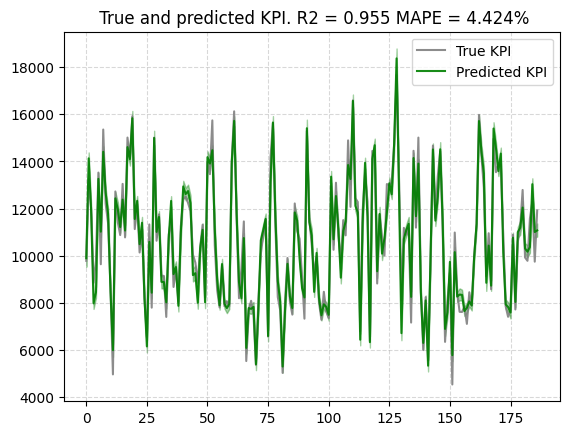

In [ ]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

#### Test Data

In [ ]:
new_predictions = mmm.predict(
    media=media_scaler.transform(media_data_test),
    target_scaler=target_scaler,
    seed=SEED
)

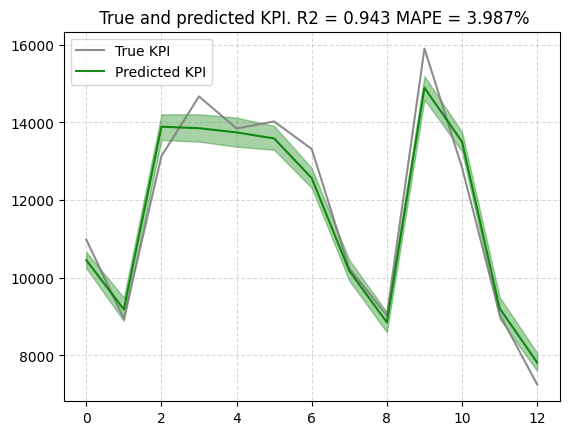

In [ ]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                  out_of_sample_target=target[split_point:])

This is a stacked area chart that displays the weekly media and baseline contributions.

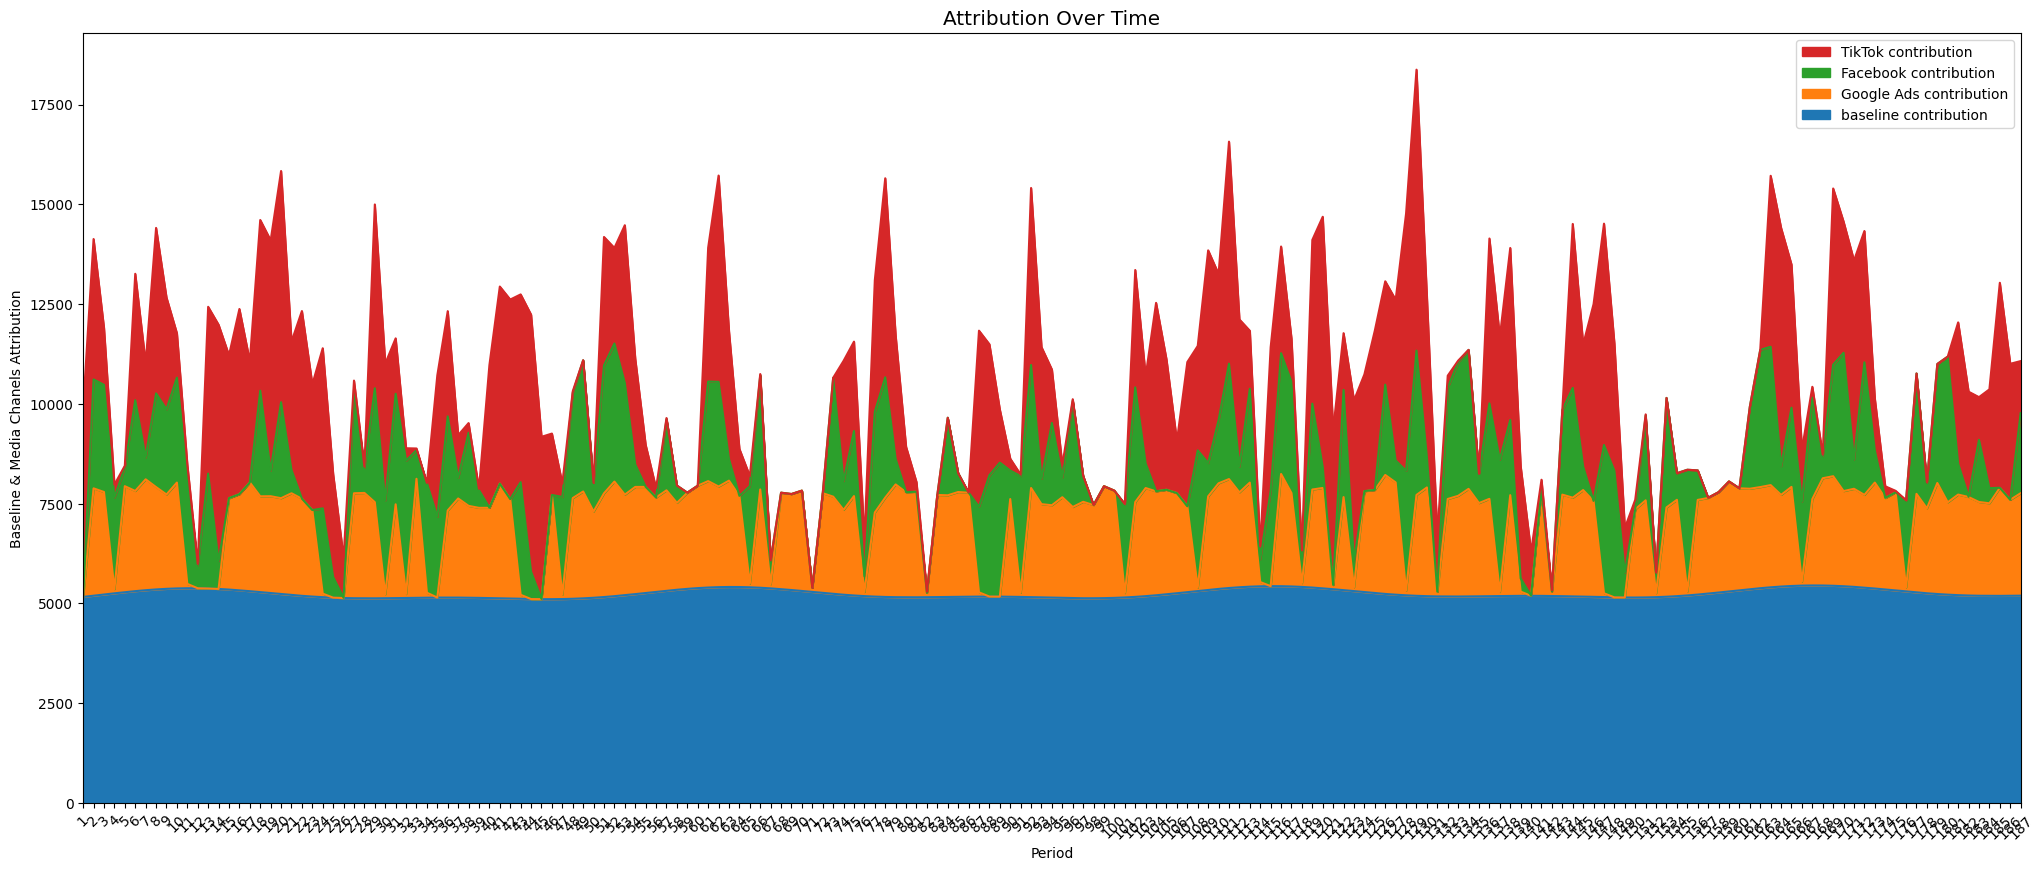

In [ ]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(25,10))

This is a table of the data shown in the plot above.

In [ ]:
plot.create_media_baseline_contribution_df(media_mix_model=mmm,
                                           target_scaler=target_scaler)

,TikTok_percentage,Facebook_percentage,Google Ads_percentage,baseline_percentage,avg_prediction,TikTok contribution,Facebook contribution,Google Ads contribution,baseline contribution,period
0,0.478022,0.000000e+00,0.000000,0.521978,9893.375000,4729.248535,0.000000,0.000000,5164.125977,1
1,0.248971,1.930927e-01,0.190336,0.367600,14130.932617,3518.198486,2728.579834,2689.623047,5194.532227,2
2,0.119788,2.255691e-01,0.215758,0.438884,11903.031250,1425.846069,2684.955811,2568.176025,5224.054199,3
3,0.040109,2.880670e-01,0.013175,0.658648,7976.036621,319.914429,2297.632568,105.086807,5253.402344,4
4,0.004827,5.584400e-02,0.314335,0.624994,8450.835938,40.789612,471.928497,2656.393066,5281.724609,5
...,...,...,...,...,...,...,...,...,...,...
182,0.104996,1.533339e-01,0.231003,0.510667,10169.044922,1067.711670,1559.259521,2349.080566,5192.992676,183
183,0.238846,3.661232e-02,0.223763,0.500779,10364.292969,2475.467285,379.460846,2319.148682,5190.216797,184
184,0.394073,2.278290e-04,0.207539,0.398161,13034.902344,5136.698242,2.969729,2705.249268,5189.986328,185
185,0.309607,2.195599e-07,0.218621,0.471772,11004.718750,3407.135010,0.002416,2405.862061,5191.719727,186


The posterior distributions show below are the estimates of the coefficients for each of the channels.

The X-axis is the estimated coefficient.

The Y-axis is the the confidence of the model in the coefficients.

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x7e72c4f93b50>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_histogram': File: numba/np/arraymath.py: Line 4071.
    With argument(s): '(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<function linspace at 0x7e72c4ef7d00>) found for signature:
    
    >>> linspace(readonly buffer(float32, 0d,

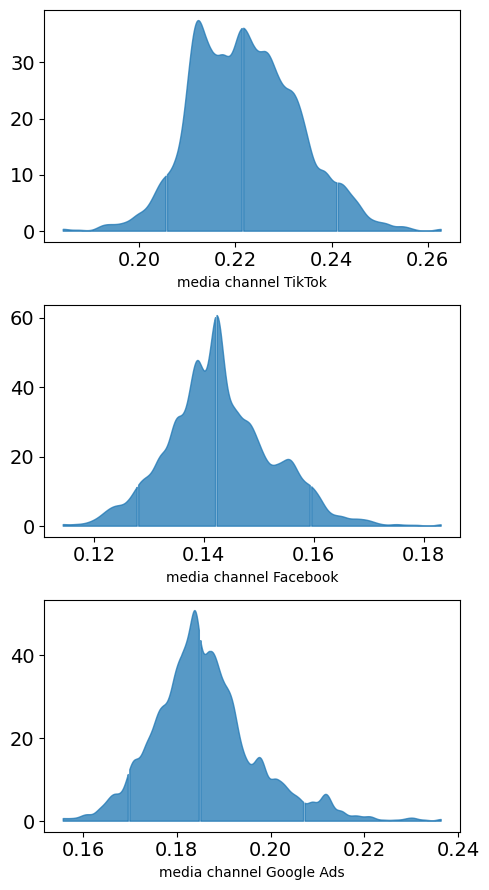

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names = channel_names)

In [ ]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

This bar chart shows the similar info to the posterior distributions above. The media contribution for each channel is given as well as their confidence interval.

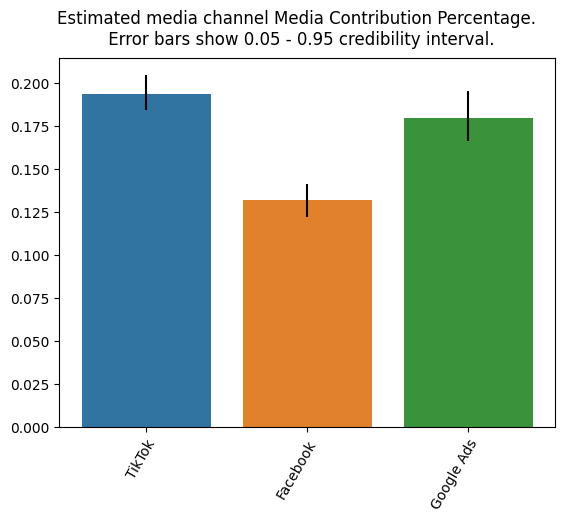

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names = channel_names)

ROI is calculated by media contribution / cost

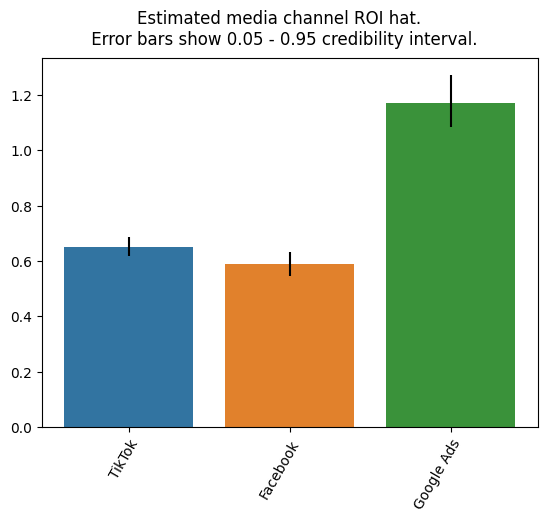

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names = channel_names)

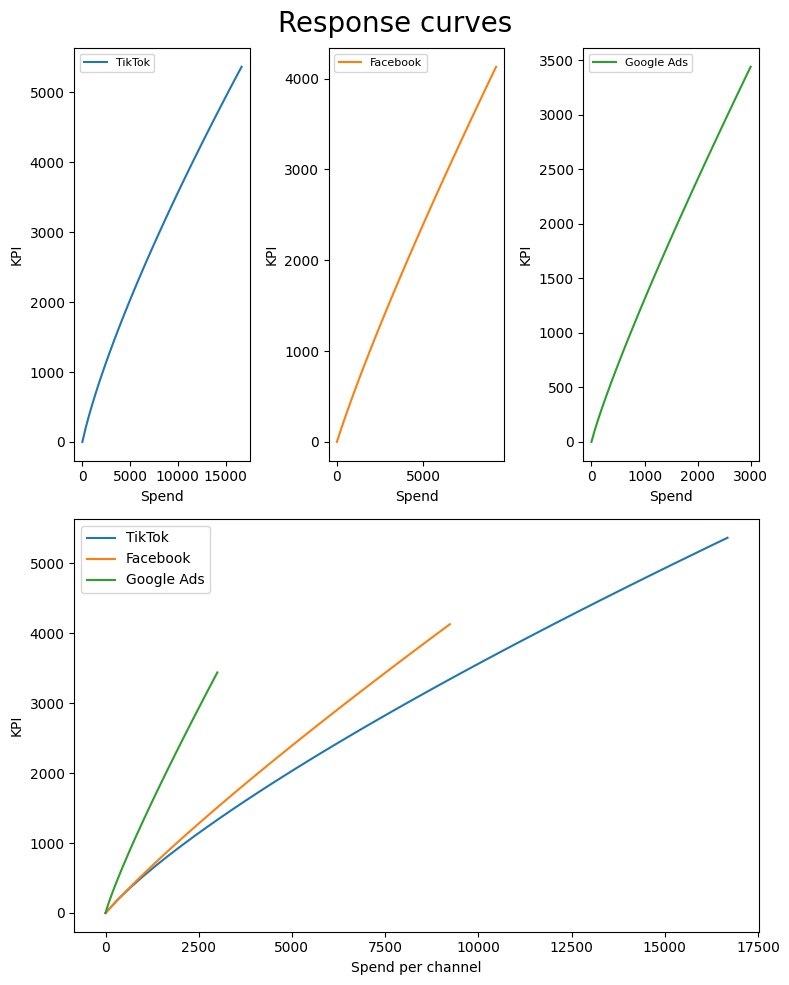

In [ ]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, media_scaler=media_scaler, seed=SEED)

# Optimization

In [ ]:
prices = jnp.ones(mmm.n_media_channels)

n_time_periods = 10
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [ ]:
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -111685.70650062108
            Iterations: 17
            Function evaluations: 119
            Gradient evaluations: 17


In [ ]:
optimal_buget_allocation = prices * solution.x
previous_budget_allocation = prices * previous_media_allocation

In [ ]:
print(budget, optimal_buget_allocation.sum())
print(budget, jnp.sum(solution.x * prices))

66805.16 66805.16
66805.16 66805.16


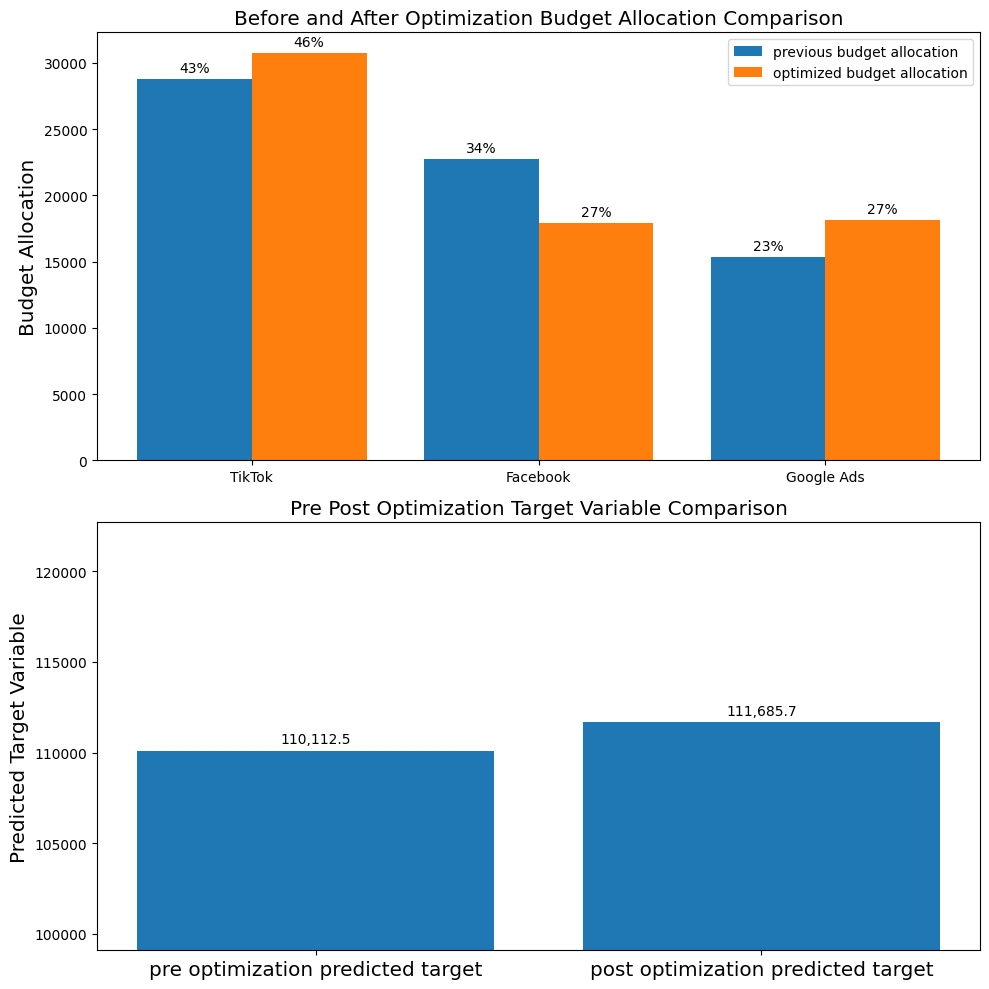

In [ ]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))